In [1]:
from qiskit.quantum_info import Statevector
from QuditsOnQubits import QuditsOnQubits
import numpy as np
import networkx as nx
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt

Definicja Z i X qutrytowych zakodowanych na qubitach

In [2]:
omega = np.exp(2*np.pi*1.j/3)
Z = [[1, 0, 0, 0], [0, omega, 0, 0], [0, 0, omega*omega, 0], [0, 0, 0, 1]]
X = [[0,0,1,0], [1,0,0,0], [0,1,0,0],[0,0,0,1]]

In [36]:
qubit0 = np.array([[1], [0]])
qubit1 = np.array([[0], [1]])

Qtrt0 = np.kron(qubit0, qubit0)
Qtrt1 = np.kron(qubit0, qubit1)
Qtrt2 = np.kron(qubit1, qubit0)

In [38]:
Qtrt0

array([[1],
       [0],
       [0],
       [0]])

In [39]:
Qtrt1

array([[0],
       [1],
       [0],
       [0]])

In [40]:
Qtrt2

array([[0],
       [0],
       [1],
       [0]])

In [45]:
np.dot(Z, Qtrt2)

array([[ 0. +0.j       ],
       [ 0. +0.j       ],
       [-0.5-0.8660254j],
       [ 0. +0.j       ]])

Tworze graf ame43

5

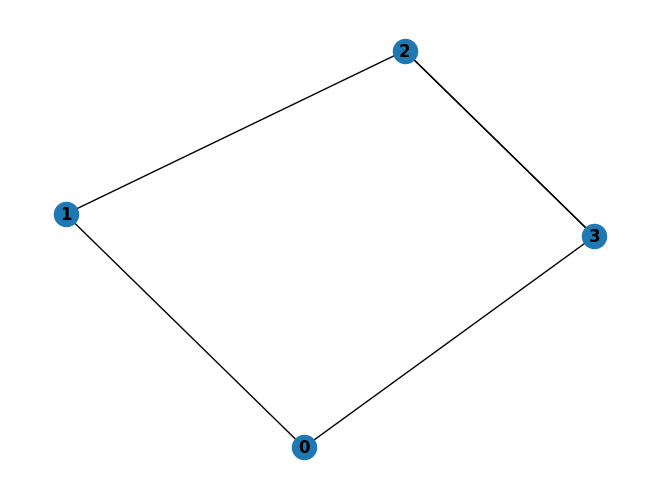

In [3]:
SQ = nx.MultiGraph()

#dodawanie wezlow
SQ.add_nodes_from([0, 3])

#dodawanie kolejnych krawedzi
SQ.add_edge(0, 1)
SQ.add_edge(1, 2)
SQ.add_edge(2, 3)
SQ.add_edge(2, 3)
SQ.add_edge(3, 0)

#rysowania grafu
nx.draw(SQ, with_labels=True, font_weight='bold')

#wypisywanie liczby krawedzi
SQ.number_of_edges()

Tworze stan grafowy uzywajac stworzonej biblioteki QuditsOnQubits gdzie w argumencie mam graf

In [4]:
ame43 = QuditsOnQubits(SQ)

Tworze obwod z grafu

In [5]:
ame43circ = ame43.circuit

Tworze stabilizatory według pracy Santosa. Wzor nr. 42 na stronie 11. 

In [6]:
G1 = np.kron(np.kron(np.kron(X, Z), np.identity(4)), Z)
G1G2 = np.kron(np.kron(np.kron(np.dot(X, Z), np.dot(Z, X)), Z), Z)
G1G2pow2 = np.kron(np.kron(np.kron(multi_dot([X, Z, Z]), multi_dot([Z, X, X])), multi_dot([Z, Z])), Z)
G3 = np.kron(np.kron(np.kron(np.identity(4), Z), X), multi_dot([Z, Z]))
G1G4 = np.kron(np.kron(np.kron(multi_dot([X, Z]), Z), multi_dot([Z, Z])), multi_dot([Z, X]))

# G1 = np.kron(X, np.kron(Z, np.kron(np.identity(4), Z)))
# G1G2 = np.kron(np.dot(X, Z), np.kron(np.kron(Z, X), np.kron(Z, Z)))
# G1G2pow2 = np.kron(np.dot(X, np.dot(Z, Z)), np.kron(np.kron(Z, np.dot(X, X)), np.kron(np.dot(Z, Z), Z)))
# G3 = np.kron(np.identity(4), np.kron(Z, np.kron(X, np.dot(Z, Z))))
# G1G4 = np.kron(np.dot(X, Z), np.kron(Z, np.kron(np.dot(Z, Z), np.dot(Z, X))))

In [35]:
G1.shape

(256, 256)

Odczytuje stan z obwodu ktory stworzylem

In [7]:
ame43state = Statevector(ame43circ).data

Obliczam wartosc oczekiwana stabilizatora G1

In [8]:
ame43matrix = ame43state.reshape(256, 1)

In [9]:
multi_dot([ame43matrix.conj().transpose(), G1, ame43matrix])

array([[-2.9629077e-15-1.54185538e-15j]])

In [10]:
G1ev = ame43state.expectation_value(G1)

AttributeError: 'numpy.ndarray' object has no attribute 'expectation_value'

In [88]:
G1ev

np.complex128(-2.949029909160572e-15-1.582067810090848e-15j)

Sprawdzam recznie ten stan ame43

In [11]:
Zsolo = [[1, 0, 0], [0, omega, 0], [0, 0, omega*omega]]
Xsolo = [[0,0,1], [1,0,0], [0,1,0]]

In [12]:
qutryt0 = np.array([[1], [0], [0]])
qutryt1 = np.array([[0], [1], [0]])
qutryt2 = np.array([[0], [0], [1]])

In [13]:
plusQutryt = 1/np.sqrt(3) * (qutryt0 + qutryt1 + qutryt2)

Bramka CZ jest diagonalna i ma na diagonali $\omega^{i * j}$, gdzie i oraz j to kombinacje wszystkich qutrytow np. $\ket{0, 0}$ mamy $\omega^{0 * 0}$, dla $\ket{0, 1}$ mamy $\omega^{0 * 1}$ itd

In [14]:
CZqutryt = np.diag([1, 1, 1, 1, omega, omega*omega, 1, omega*omega, omega])

Robie plusy na kazdym wierzcholku

In [15]:
stanPlus = np.kron(np.kron(np.kron(plusQutryt, plusQutryt), plusQutryt), plusQutryt)

In [16]:
CZ01 = np.kron(CZqutryt, np.kron(np.identity(3), np.identity(3)))
CZ12 = np.kron(np.identity(3), np.kron(CZqutryt, np.identity(3)))
CZ23 = np.kron(np.identity(3), np.kron(np.identity(3), CZqutryt))

Robie funkcje poniewaz nie moge bezposrednio uzyc np.kron bo qutryty nie sa obok siebie tylko na dwoch koncach, wiec tworze juz caly stan CZ03 odrazu.

In [17]:
def CZ_30_4qutrits():
    d = 3
    dim = d**4
    diag_elements = np.zeros(dim, dtype=complex)

    omega = np.exp(2j * np.pi / d) 

    index = 0
    for x0 in range(d):
        for x1 in range(d):
            for x2 in range(d):
                for x3 in range(d):
                    
                    diag_elements[index] = omega ** (x0 * x3)
                    index += 1

    return np.diag(diag_elements)

CZ30 = CZ_30_4qutrits()

Robie CZ na kazdej krawedzi i lacze ze stanem plus na kazdym wierzcholku

In [18]:
ame43test = multi_dot([CZ01, CZ12, CZ23, CZ23, CZ30, stanPlus])

In [19]:
ame43test.shape

(81, 1)

Analogicznie do tworzenia poprzednich stabilizatorow

In [20]:
G1test = np.kron(np.kron(np.kron(Xsolo, Zsolo), np.identity(3)), Zsolo)
G1G2test = np.kron(np.kron(np.kron(np.dot(Xsolo, Zsolo), np.dot(Zsolo, Xsolo)), Zsolo), Zsolo)
G1G2pow2test = np.kron(np.kron(np.kron(multi_dot([Xsolo, Zsolo, Zsolo]), multi_dot([Zsolo, Xsolo, Xsolo])), multi_dot([Zsolo, Zsolo])), Zsolo)
G3test = np.kron(np.kron(np.kron(np.identity(3), Zsolo), Xsolo), multi_dot([Zsolo, Zsolo]))
G1G4test = np.kron(np.kron(np.kron(multi_dot([Xsolo, Zsolo]), Zsolo), multi_dot([Zsolo, Zsolo])), multi_dot([Zsolo, Xsolo]))

# G1test = np.kron(Xsolo, np.kron(Zsolo, np.kron(np.identity(3), Zsolo)))
# G1G2test = np.kron(np.dot(Xsolo, Zsolo), np.kron(np.kron(Zsolo, Xsolo), np.kron(Zsolo, Zsolo)))
# G1G2pow2test = np.kron(np.dot(Xsolo, np.dot(Zsolo, Zsolo)), np.kron(np.kron(Zsolo, np.dot(Xsolo, Xsolo)), np.kron(np.dot(Zsolo, Zsolo), Zsolo)))
# G3test = np.kron(np.identity(3), np.kron(Zsolo, np.kron(Xsolo, np.dot(Zsolo, Zsolo))))
# G1G4test = np.kron(np.dot(Xsolo, Zsolo), np.kron(Zsolo, np.kron(np.dot(Zsolo, Zsolo), np.dot(Zsolo, Xsolo))))

Obliczam recznie $\braket{ame43|G1|ame43}$

In [21]:
multi_dot([ame43test.conj().transpose(), G1test, ame43test])

array([[1.-4.21537805e-16j]])

In [22]:
operatory = [G1test, G1G2test, G1G2pow2test, G3test, G1G4test]

In [23]:
suma = 0
for i in operatory:
    suma += np.real(multi_dot([ame43test.conj().transpose(), i, ame43test]))
    print(np.real(multi_dot([ame43test.conj().transpose(), i, ame43test])))
    
print(suma)

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[5.]]


In [24]:
def exp_val(op):
    return np.real(multi_dot([ame43test.conj().transpose(), op, ame43test]))

In [25]:
B_ame = G1test + G1G2pow2test + 0.5*(G1G2test + G1G4test) + G3test + G1test.conj().T + G1G2pow2test.conj().T + 0.5*(G1G2test.conj().T + G1G4test.conj().T) + G3test.conj().T

In [26]:
np.real(multi_dot([ame43test.conj().transpose(), B_ame, ame43test]))

array([[8.]])

Porownanie z wczesniejszym wynikiem

In [34]:
Statevector(ame43test).draw('latex')

<IPython.core.display.Latex object>

In [46]:
Statevector(ame43matrix).draw('latex')

<IPython.core.display.Latex object>

In [48]:
nonzero_dict = Statevector(ame43test).to_dict()
num_terms = len(nonzero_dict)
print("Liczba niezerowych składników w tym Statevector:", num_terms)

Liczba niezerowych składników w tym Statevector: 81


In [34]:
G1ev

NameError: name 'G1ev' is not defined

In [38]:
diff = ame43matrix - am43test

NameError: name 'am43test' is not defined

In [2]:
ghz_circ = QuditsOnQubits().circuit

In [3]:
ghz_circ[0].remove_final_measurements()

In [ ]:
ghz_circ[1]

In [116]:
ghz_circ

In [4]:
ghz_matrix = Statevector(ghz_circ[1])

In [5]:
ghz_matrix.draw('latex')

<IPython.core.display.Latex object>

In [8]:
g1 = np.kron(np.kron(Z, X), X)
g2 = np.kron(np.kron(X, Z), np.identity(4))
g3 = np.kron(np.kron(X, np.identity(4)), Z)

In [13]:
multi_dot([ghz_matrix.data.conj().transpose(), g1, ghz_matrix.data])

np.complex128(-2.4421441894360897e-16+1.5402969882312747e-18j)